In [1]:
# === Шаг 1: Импорт необходимых библиотек ===
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import os # Добавим для удобной работы с путями

# === Шаг 2: Настройка и загрузка модели (делается один раз) ===

# Проверяем доступность CUDA и устанавливаем устройство
if torch.cuda.is_available():
    device = "cuda"
    print(f"CUDA доступна! Используем GPU: {torch.cuda.get_device_name(0)}")
else:
    device = "cpu"
    print("CUDA недоступна, используется CPU. Это будет медленно.")

# Пути к модели
model_checkpoint_path = "/workspace/SSCloud/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

# Загружаем модель в память
print("\nЗагрузка модели Segment Anything...")
sam = sam_model_registry[model_type](checkpoint=model_checkpoint_path)
sam.to(device=device)
print("Модель успешно загружена.")

# Инициализируем генератор масок с настройками для умного масштабирования
print("Инициализируем генератор масок с настройками для умного масштабирования...")
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,          # Увеличим плотность сетки для лучшего качества на едином изображении
    pred_iou_thresh=0.92,        # Порог качества: оставляем только маски, в которых модель уверена > 92%
    stability_score_thresh=0.96, # Порог стабильности: маска не должна сильно меняться при небольшом изменении порога
    box_nms_thresh=0.7,          # Порог подавления дублей
    crop_n_layers=1,             # Включаем небольшую автоматическую нарезку внутри модели, это улучшает качество
    crop_n_points_downscale_factor=2,
    min_mask_region_area=1000    # ВАЖНО: Минимальная площадь для УМЕНЬШЕННОГО изображения. Отсеиваем мелкий шум.
)
print("Генератор масок готов к работе.")

CUDA доступна! Используем GPU: NVIDIA RTX A5000

Загрузка модели Segment Anything...
Модель успешно загружена.
Инициализируем генератор масок с настройками для умного масштабирования...
Генератор масок готов к работе.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import shutil
import xml.etree.ElementTree as ET
from xml.dom import minidom
import zipfile
import torch # Добавлен импорт torch для очистки кэша CUDA

# ==============================================================================
# -------- КОНФИГУРАЦИЯ: Для изменения переменных ------------------------------
# ==============================================================================

PANORAMA_FILENAME = "3_normals.jpg"
BASE_INPUT_DIR = "Vistino20241014_E57"
MAIN_OUTPUT_DIR = "CVAT_Workspace"
CLASS_NAMES = ["Фон", "Земля", "Человек", "Растительность", "Транспорт", "Конструкции", "Здание"]
HIGHLIGHT_COLOR_BGR = (0, 255, 0)

# --- НОВАЯ НАСТРОЙКА ---
# Максимальный размер длинной стороны панорамы для обработки.
# Уменьшите (например, до 3000), если снова возникнет ошибка памяти.
# Увеличьте (например, до 5000), если у вас мощная GPU.
MAX_DIMENSION = 4000

# ==============================================================================
# -------------------------ЛОГИКА СКРИПТА --------------------------------------
# ==============================================================================

class PanoramaProcessor:
    def __init__(self, panorama_filename, input_dir, output_dir, class_names):
        self.panorama_filename = panorama_filename
        self.panorama_base_name = os.path.splitext(panorama_filename)[0]
        self.input_dir = input_dir
        
        self.pano_output_dir = os.path.join(output_dir, self.panorama_base_name)
        self.source_masks_dir = os.path.join(self.pano_output_dir, "1_generated_masks")
        self.classified_masks_dir = os.path.join(self.pano_output_dir, "2_classified_masks")
        self.final_mask_dir = os.path.join(self.pano_output_dir, "3_final_mask")
        self.labelme_dir = os.path.join(self.pano_output_dir, "4_labelme_xml")
        self.final_zip_dir = os.path.join(self.pano_output_dir, "5_upload_to_cvat")
        
        self.class_names = class_names
        self.class_mapping = {name.strip().replace(" ", "_"): i + 1 for i, name in enumerate(class_names)}
        
        self.original_panorama_path = os.path.join(self.input_dir, self.panorama_filename)
        self.original_panorama = None
        self.original_panorama_rgb = None
        
        self.mask_files = []
        self.current_mask_index = 0
        self.is_stopped = False
        
        self.output_area = widgets.Output()
        self.buttons = [widgets.Button(description=name, button_style='primary') for name in self.class_names]
        self.buttons.extend([
            widgets.Button(description="Пропустить", button_style='info'),
            widgets.Button(description="Стоп", button_style='danger')
        ])
        self.button_box = widgets.HBox(self.buttons)

    # --- Методы для Ячейки 1 ---
    def setup_and_load(self):
        print(f"Настройка папок в: {self.pano_output_dir}")
        for path in [self.source_masks_dir, self.classified_masks_dir, self.final_mask_dir, self.labelme_dir, self.final_zip_dir]:
            os.makedirs(path, exist_ok=True)
        if not os.path.exists(self.original_panorama_path):
            print(f"ОШИБКА: Панорама не найдена: {self.original_panorama_path}")
            return False
        self.original_panorama = cv2.imread(self.original_panorama_path)
        self.original_panorama_rgb = cv2.cvtColor(self.original_panorama, cv2.COLOR_BGR2RGB)
        print(f"Панорама успешно найдена.")
        return True

    def generate_masks(self, sam_mask_generator):
        print("\n--- Шаг 1: Генерация масок (метод умного масштабирования) ---")
        if os.listdir(self.source_masks_dir):
            print("Маски уже сгенерированы. Пропускаем.")
            return

        full_height, full_width, _ = self.original_panorama_rgb.shape
        
        # --- Умное масштабирование ---
        print(f"Исходный размер панорамы: {full_width}x{full_height}")
        scale = MAX_DIMENSION / max(full_height, full_width)
        
        target_width = int(full_width * scale)
        target_height = int(full_height * scale)
        
        print(f"Масштабирую до {target_width}x{target_height} для экономии памяти...")
        downscaled_panorama = cv2.resize(
            self.original_panorama_rgb, 
            (target_width, target_height), 
            interpolation=cv2.INTER_AREA
        )
        
        print("Запускаю сегментацию на уменьшенной панораме...")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        downscaled_masks = sam_mask_generator.generate(downscaled_panorama)
        
        print("Сегментация завершена. Масштабирую маски до исходного размера и сохраняю...")
        mask_counter = 0
        for mask_ann in downscaled_masks:
            small_mask_uint8 = mask_ann['segmentation'].astype(np.uint8)
            
            # Масштабируем маску обратно до полного размера
            full_size_mask = cv2.resize(
                small_mask_uint8,
                (full_width, full_height), # Целевой размер - исходный
                interpolation=cv2.INTER_NEAREST
            )
            
            final_mask_to_save = full_size_mask * 255
            cv2.imwrite(os.path.join(self.source_masks_dir, f"mask_{mask_counter}.png"), final_mask_to_save)
            mask_counter += 1
            
        print(f"\nГотово! Всего найдено и сохранено {mask_counter} масок.")
        
    def run_classification(self):
        print("\n--- Шаг 2: Интерактивная классификация ---")
        self.mask_files = sorted([f for f in os.listdir(self.source_masks_dir) if f.endswith('.png')])
        if not self.mask_files:
            print("Нет масок для классификации. Можно запускать следующую ячейку.")
            return
        print("Нажимайте на кнопки для присвоения класса.")
        for btn in self.buttons: btn.on_click(self._on_button_click)
        display(self.button_box, self.output_area)
        self._display_current_mask()

    def _display_current_mask(self):
        if self.is_stopped or self.current_mask_index >= len(self.mask_files):
            with self.output_area:
                clear_output()
                msg = "Все маски классифицированы!" if not self.is_stopped else "Процесс остановлен."
                print(f"{msg}\nТеперь можно запускать следующую ячейку для создания ZIP-архива.")
            for btn in self.buttons: btn.disabled = True
            return
            
        filename = self.mask_files[self.current_mask_index]
        filepath = os.path.join(self.source_masks_dir, filename)
        mask_image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        
        overlay = np.zeros_like(self.original_panorama)
        overlay[mask_image > 0] = HIGHLIGHT_COLOR_BGR
        highlighted = cv2.addWeighted(self.original_panorama, 1, overlay, 0.6, 0)
        
        with self.output_area:
            clear_output(wait=True)
            fig, axes = plt.subplots(3, 1, figsize=(15, 12))
            fig.suptitle(f"Осталось: {len(self.mask_files) - self.current_mask_index} масок", fontsize=16)
            axes[0].imshow(self.original_panorama_rgb); axes[0].set_title("1. Оригинальная панорама"); axes[0].axis('off')
            axes[1].imshow(mask_image, cmap='gray'); axes[1].set_title(f"2. Текущая маска: {filename}"); axes[1].axis('off')
            axes[2].imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB)); axes[2].set_title("3. Подсветка текущей маски"); axes[2].axis('off')
            plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    def _on_button_click(self, button):
        action = button.description
        if action == "Стоп":
            self.is_stopped = True
        else:
            filename = self.mask_files[self.current_mask_index]
            source_path = os.path.join(self.source_masks_dir, filename)
            if action != "Пропустить" and os.path.exists(source_path):
                clean_name = action.strip().replace(" ", "_")
                new_filename = f"{self.panorama_base_name}_{clean_name}_{self.current_mask_index}.png"
                dest_path = os.path.join(self.classified_masks_dir, new_filename)
                shutil.move(source_path, dest_path)
            self.current_mask_index += 1
        self._display_current_mask()
        
    # --- Метод для Ячейки 2 ---
    def create_final_dataset(self):
        print("\n--- Шаг 3: Сборка и экспорт финального датасета ---")
        if not os.listdir(self.classified_masks_dir):
            print("Нет классифицированных масок для экспорта.")
            return

        height, width, _ = self.original_panorama.shape
        final_mask = np.zeros((height, width), dtype=np.uint8)
        
        for filename in os.listdir(self.classified_masks_dir):
            try:
                class_name_clean = filename.split('_')[2] # Получаем очищенное имя класса
                if class_name_clean in self.class_mapping:
                    class_id = self.class_mapping[class_name_clean]
                    mask = cv2.imread(os.path.join(self.classified_masks_dir, filename), cv2.IMREAD_GRAYSCALE)
                    if mask is not None: final_mask[mask > 0] = class_id
            except (IndexError, KeyError): continue
        
        final_mask_path = os.path.join(self.final_mask_dir, f"{self.panorama_base_name}_mask.png")
        cv2.imwrite(final_mask_path, final_mask)
        print(f"Финальная маска сохранена.")
        
# --- Главный блок выполнения ---
if 'mask_generator' in locals():
    # Создаем глобальную переменную процессора, чтобы другие ячейки имели к ней доступ
    classifier = PanoramaProcessor(PANORAMA_FILENAME, BASE_INPUT_DIR, MAIN_OUTPUT_DIR, CLASS_NAMES)
    if classifier.setup_and_load():
        classifier.generate_masks(mask_generator)
        classifier.run_classification()
else:
    print("ОШИБКА: Сначала запустите ячейку с инициализацией `mask_generator`.")

Настройка папок в: CVAT_Workspace/3_normals
Панорама успешно найдена.

--- Шаг 1: Генерация масок (метод умного масштабирования) ---
Исходный размер панорамы: 16660x6525
Масштабирую до 4000x1566 для экономии памяти...
Запускаю сегментацию на уменьшенной панораме...
Сегментация завершена. Масштабирую маски до исходного размера и сохраняю...

Готово! Всего найдено и сохранено 28 масок.

--- Шаг 2: Интерактивная классификация ---
Нажимайте на кнопки для присвоения класса.


Output()

--- Сборка и визуализация финальной маски ---
Собираем маски...
Промежуточная маска сохранена: CVAT_Workspace/2_normals/3_final_mask/2_normals_mask.png
Отрисовка результата...


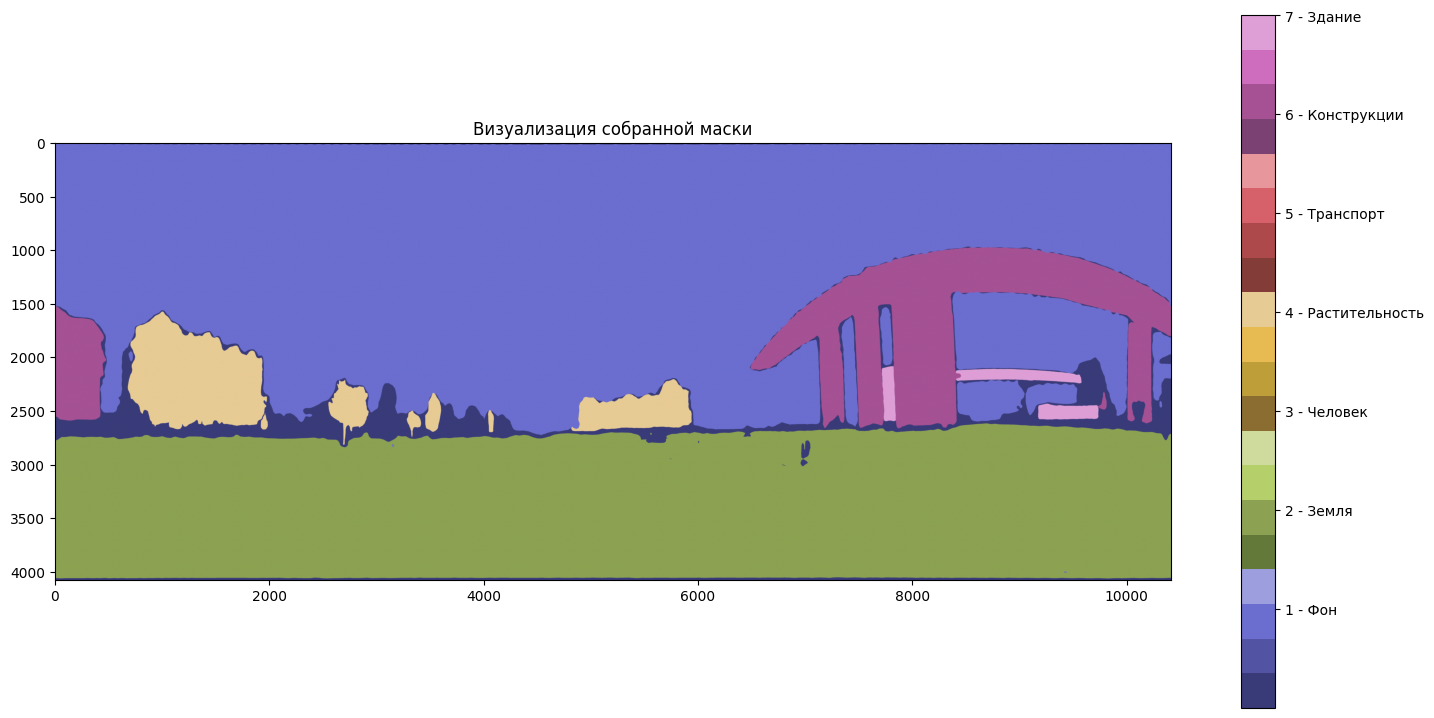


Визуализация завершена. Если все верно, запускайте следующую ячейку.


In [8]:
# --- ЯЧЕЙКА ДЛЯ ВИЗУАЛИЗАЦИИ ---
# Запустите эту ячейку после того, как закончите классификацию.

if 'classifier' in locals() and isinstance(classifier, PanoramaProcessor):
    print("--- Сборка и визуализация финальной маски ---")
    
    classified_files = os.listdir(classifier.classified_masks_dir)
    if not classified_files:
        print("Нет классифицированных масок для визуализации.")
    else:
        height, width, _ = classifier.original_panorama.shape
        # Создаем пустой холст для финальной маски
        final_mask = np.zeros((height, width), dtype=np.uint8)
        
        print("Собираем маски...")
        # Собираем маску из отдельных файлов
        for filename in classified_files:
            try:
                class_name_clean = filename.split('_')[2]
                if class_name_clean in classifier.class_mapping:
                    class_id = classifier.class_mapping[class_name_clean]
                    mask = cv2.imread(os.path.join(classifier.classified_masks_dir, filename), cv2.IMREAD_GRAYSCALE)
                    if mask is not None:
                        final_mask[mask > 0] = class_id
            except (IndexError, KeyError):
                continue
        
        # Сохраняем собранную маску
        final_mask_path = os.path.join(classifier.final_mask_dir, f"{classifier.panorama_base_name}_mask.png")
        cv2.imwrite(final_mask_path, final_mask)
        print(f"Промежуточная маска сохранена: {final_mask_path}")

        # Визуализация
        print("Отрисовка результата...")
        fig, ax = plt.subplots(1, 1, figsize=(18, 9))
        im = ax.imshow(final_mask, cmap='tab20b')
        ax.set_title("Визуализация собранной маски")
        
        # --- ИЗМЕНЕНИЕ ЗДЕСЬ ---
        # Создаем список с ID и именами для легенды
        ticks = sorted(list(classifier.class_mapping.values()))
        tick_labels = [f"{i} - {name.replace('_', ' ')}" for name, i in sorted(classifier.class_mapping.items(), key=lambda item: item[1])]
        
        # Создаем красивую легенду (colorbar)
        cbar = fig.colorbar(im, ax=ax, ticks=ticks)
        cbar.set_ticklabels(tick_labels)
        
        plt.show()
        print("\nВизуализация завершена. Если все верно, запускайте следующую ячейку.")

else:
    print("❌ ОШИБКА: Объект 'classifier' не найден. Сначала запустите первую ячейку.")

In [9]:
# --- ЯЧЕЙКА ДЛЯ ФИНАЛЬНОГО ЭКСПОРТА ---
# Запустите эту ячейку после визуализации.

def create_labelme_and_zip(processor):
    """Создание XML и ZIP на основе уже собранной маски."""
    print("\n--- Шаг 3: Создание финального датасета для CVAT ---")

    final_mask_path = os.path.join(processor.final_mask_dir, f"{processor.panorama_base_name}_mask.png")
    if not os.path.exists(final_mask_path):
        print(f"ОШИБКА: Не найден файл собранной маски: {final_mask_path}")
        print("Пожалуйста, сначала запустите ячейку для визуализации.")
        return
        
    final_mask = cv2.imread(final_mask_path, cv2.IMREAD_GRAYSCALE)
    height, width = final_mask.shape

    # --- Создание LabelMe XML ---
    print("Создание XML-файла...")
    annotation = ET.Element('annotation')
    ET.SubElement(annotation, 'filename').text = processor.panorama_filename
    ET.SubElement(annotation, 'folder').text = ''
    imagesize = ET.SubElement(annotation, 'imagesize')
    ET.SubElement(imagesize, 'nrows').text = str(height)
    ET.SubElement(imagesize, 'ncols').text = str(width)
    
    object_counter = 0
    id_to_name_map = {v: k for k, v in processor.class_mapping.items()}
    
    for class_id in np.unique(final_mask):
        if class_id == 0: continue
        binary_mask = np.uint8(final_mask == class_id) * 255
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        original_class_name = list(processor.class_mapping.keys())[list(processor.class_mapping.values()).index(class_id)].replace("_", " ")
        
        for contour in contours:
            if cv2.contourArea(contour) < 5: continue
            obj = ET.SubElement(annotation, 'object')
            ET.SubElement(obj, 'name').text = original_class_name
            ET.SubElement(obj, 'deleted').text = '0'
            ET.SubElement(obj, 'id').text = str(object_counter)
            object_counter += 1
            polygon = ET.SubElement(obj, 'polygon')
            for point in contour.squeeze():
                pt = ET.SubElement(polygon, 'pt')
                ET.SubElement(pt, 'x').text = str(int(point[0]))
                ET.SubElement(pt, 'y').text = str(int(point[1]))

    xml_string = ET.tostring(annotation, 'utf-8')
    reparsed = minidom.parseString(xml_string)
    pretty_xml = '\n'.join(reparsed.toprettyxml(indent="  ").split('\n')[1:])
    final_xml = '<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n' + pretty_xml
    
    xml_filepath = os.path.join(processor.labelme_dir, f"{processor.panorama_base_name}.xml")
    with open(xml_filepath, 'w', encoding='utf-8') as f: f.write(final_xml)
    print(f"XML-аннотация сохранена.")
    
    # --- Создание ZIP-архива ---
    print("Создание ZIP-архива...")
    zip_filepath = os.path.join(processor.final_zip_dir, f"{processor.panorama_base_name}_for_cvat.zip")
    with zipfile.ZipFile(zip_filepath, 'w') as zipf:
        zipf.write(processor.original_panorama_path, arcname=processor.panorama_filename)
        zipf.write(xml_filepath, arcname=f"{processor.panorama_base_name}.xml")
        
    print("\n----------------------------------------------------")
    print(f"ZIP-архив готов для загрузки в CVAT:")
    print(f"{zip_filepath}")

if 'classifier' in locals() and isinstance(classifier, PanoramaProcessor):
    create_labelme_and_zip(classifier)
else:
    print("ОШИБКА: Объект 'classifier' не найден. Сначала запустите первую ячейку.")


--- Шаг 3: Создание финального датасета для CVAT ---
Создание XML-файла...
XML-аннотация сохранена.
Создание ZIP-архива...

----------------------------------------------------
ZIP-архив готов для загрузки в CVAT:
CVAT_Workspace/2_normals/5_upload_to_cvat/2_normals_for_cvat.zip
